

---
# RNN
## Authors:
Kamil Kaczor 173367 </br>
Marta Zielonka 171712 </br>
Date: 15.01.2022</br>
</br>
---





---
Data preparation
---


In [ ]:
import pandas as pd
import tensorboard
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive
from tensorflow.keras.regularizers import L2
from scipy import stats
from numpy.testing._private.utils import measure
%load_ext tensorboard

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install openpyxl == 3.0.9

In [ ]:
!ls "/content/gdrive/MyDrive/Infa/2 stopień 2 sem./model_UM_2"

best_model.data-00000-of-00001	data_JA_df_evaluation.xlsx
best_model.index		data_JA_df_training.xlsx
checkpoint


In [ ]:
data_train = pd.read_excel('/content/gdrive/MyDrive/Infa/2 stopień 2 sem./model_UM_2/data_JA_df_training.xlsx')
data_test = pd.read_excel('/content/gdrive/MyDrive/Infa/2 stopień 2 sem./model_UM_2/data_JA_df_evaluation.xlsx')

In [ ]:
mean_train = []
std_train = []
mean_test = []
std_test = []

# Get mean and standard deviation for each attribute (train and test datasets)
for i in data_train.keys():
  mean_train.append(np.mean(data_train[:][i]))
  std_train.append(np.std(data_train[:][i]))
  mean_test.append(np.mean(data_train[:][i]))
  std_test.append(np.std(data_train[:][i]))

tmp = 0

row_counter = 0
for measurement in data_train.values:
  counter = 0
  for cell in measurement:
    if cell - mean_train[counter] > 3*std_train[counter]:
      tmp += 1
      data_train = data_train.drop(row_counter)
      break
    counter+=1
  row_counter += 1


tmp = 0
row_counter = 0

counter_outliersow = 0
for measurement in data_test.values:
  counter = 0
  for cell in measurement:
    if cell - mean_test[counter] > 3*std_test[counter]:
      tmp += 1
      data_test = data_test.drop(row_counter)
      break
    counter+=1
  row_counter += 1



---
Preprocessing

---


In [ ]:
data_test = data_test.sort_values(by=['station_id','year', 'month', 'day'])
data_train = data_train.sort_values(by=['station_id','year', 'month', 'day'])

In [ ]:
unique_train_ids = data_train['station_id'].unique()
unique_test_ids = data_test['station_id'].unique()

[474020 474050 474090 474110 474120 474260 474300 474330 474350 474400
 475200 475700 475740 475760 475810 475820 475840 475850 475880 475950
 475980 476000 476020 476060 476070 476100 476170 476180 476200 476240
 476290 476310 476360 476380 476410 476490 476530 476540 476550 476620
 476680 476720 476740 476770 476840 477400 477410 477420 477440 477460
 477470 477500 477550 477590 477620 477650 477660 477670 477690 477720
 477760 478000 478070 478090 478120 478140 478150 478170 478190 478220
 478230 478240 478270 478300 478350 478360 478380 478430 478870 478900
 478910 478920 478930 478970 478980 479090 479120 479290 479420 479450] 

[474240 475120 475870 476040 476050 476120 476370 477560 478050 479710]


In [ ]:
norm_train = data_train
norm_test = data_test

mean_train = []
var_train = []
mean_test = []
var_test = []

epsilon = 0.0001


counter = 0
for i in data_train.keys():
  mean_train.append(np.mean(norm_train[:][i]))
  var_train.append(np.var(norm_train[:][i]))
  mean_test.append(np.mean(norm_train[:][i]))
  var_test.append(np.var(norm_train[:][i]))

  norm_train[:][i] = (norm_train[:][i] - mean_train[counter])/np.sqrt(var_train[counter]+epsilon)
  norm_test[:][i] = (norm_test[:][i] - mean_test[counter])/np.sqrt(var_test[counter]+epsilon)

  counter += 1


In [ ]:
# train
grouped_train = norm_train.groupby('station_id')    
grouped_data_train = [grouped_train.get_group(z) for z in grouped_train.groups]#list of DataFrames

# test
grouped_test = norm_test.groupby('station_id')    
grouped_data_test = [grouped_test.get_group(z) for z in grouped_test.groups]#list of DataFrames

In [ ]:
columns = ['mean temperature [deg F]', 'mean dew point [deg F]', 'mean pressure (sea level) [Pa]', 'mean pressure (station) [Pa]', 'mean visibility [mile]', 'mean wind speed [knot]', 'max wind gust [knot]', 'max temperature [deg F]', 'min temperature [deg F]', 'total precipitation [inch]', 'snow depth [inch]', 'day', 'month']

iterator = 0

data_train_dict = {}
data_test_dict = {}
for i in unique_train_ids:
  data_train_dict[i] = grouped_data_train[iterator][columns][:]
  iterator += 1
  
iterator = 0
for i in unique_test_ids:
  data_test_dict[i] = grouped_data_test[iterator][columns][:]
  iterator += 1


In [ ]:
train_x = []
train_y = []

month_len = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for station in data_train_dict.keys():
  for i in range(len(data_train_dict[station]) - 15):
    intermediate = []
    counter = 0
    for j in range(i, i + 15, 1):
      add = False
      # normal
      if data_train_dict[station].iloc[j]['day'] == data_train_dict[station].iloc[j - 1]['day'] + 1:
            add = True
      # next month
      elif data_train_dict[station].iloc[j - 1]['day'] == month_len[int(data_train_dict[station].iloc[j]['month']) - 1] and data_train_dict[station].iloc[j]['day']== 1:
            add = True
      
      if add == False:
        break

      if counter % 14 == 0 and counter != 0:
        train_y.append(data_train_dict[station].iloc[j]['mean temperature [deg F]'])
      else:
        intermediate.append(data_train_dict[station].iloc[j])
      counter += 1

    if counter == 15:
      train_x.append(intermediate)

In [ ]:
test_x = []
test_y = []

month_len = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

for station in data_test_dict.keys():
  for i in range(len(data_test_dict[station]) - 15):
    intermediate = []
    counter = 0
    for j in range(i, i + 15, 1):
      add = False
      # normal
      if data_test_dict[station].iloc[j]['day'] == data_test_dict[station].iloc[j - 1]['day'] + 1:
            add = True
      # next month
      elif data_test_dict[station].iloc[j - 1]['day'] == month_len[int(data_test_dict[station].iloc[j]['month']) - 1] and data_test_dict[station].iloc[j]['day'] == 1:
            add = True
      if add == False:
        break

      if counter % 14 == 0 and counter != 0:
        test_y.append(data_test_dict[station].iloc[j]['mean temperature [deg F]'])
      else:
        intermediate.append(data_test_dict[station].iloc[j])
      counter += 1

    if counter == 15:
      test_x.append(intermediate)


In [ ]:
train_y = np.array(train_y)
train_x = np.array(train_x)

test_y = np.array(test_y)
test_x = np.array(test_x)

In [ ]:
train_x = np.delete(train_x, [-1, -2], axis = 2)
test_x = np.delete(test_x, [-1, -2], axis = 2)



---

Klasyfikacja

---

In [ ]:
# weight_decay parameter
wd = 0.000005

act = 'relu'
#act = 'elu'

# w_init = 'random_uniform'
# w_init = 'random_normal'
# w_init = 'glorot_uniform'
w_init = 'glorot_normal'
#w_init = 'he_uniform'
# w_init = 'he_normal'
# w_init = 'zeros'
# b_init = 'zeros'
b_init = 'ones'


model2 = keras.Sequential()
model2.add(layers.LSTM(
        units = 1596,
        kernel_regularizer = L2(wd), bias_regularizer = L2(wd),
        kernel_initializer = w_init, bias_initializer = b_init))
model2.add(layers.Dense(512, activation = act,
                               kernel_regularizer = L2(wd), bias_regularizer = L2(wd),
                               kernel_initializer = w_init, bias_initializer = b_init))
model2.add(layers.Dense(256, activation = act,
                               kernel_regularizer = L2(wd), bias_regularizer = L2(wd),
                               kernel_initializer = w_init, bias_initializer = b_init))
model2.add(layers.Dense(1, activation = 'linear'))

model2.build(input_shape=(1, 14, 11))

model2.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 1596)                 10265472  
                                                                 
 dense_2 (Dense)             (1, 512)                  817664    
                                                                 
 dense_3 (Dense)             (1, 1)                    513       
                                                                 
Total params: 11,083,649
Trainable params: 11,083,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), loss = 'mse', metrics = 'mse')

In [ ]:
filepath = "/content/gdrive/MyDrive/Infa/2 stopień 2 sem./model_UM_2/best_model"
log_directory = "./test"

# TENSORBOARD
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory)

# CHECKPOINT
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor = "val_mse",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "min",
    save_freq = "epoch"
)

In [ ]:
#model2.load_weights(filepath)

In [ ]:
model2.fit(train_x, train_y, epochs = 100, verbose = 1, callbacks = [tensorboard_callback, checkpoint], validation_split = 0.20)

Epoch 1/100
289/290 [============================>.] - ETA: 0s - loss: 0.4867 - mse: 0.4863
Epoch 00001: val_mse did not improve from 0.05091
290/290 [==============================] - 17s 50ms/step - loss: 0.4856 - mse: 0.4852 - val_loss: 0.0587 - val_mse: 0.0583
Epoch 2/100
289/290 [============================>.] - ETA: 0s - loss: 0.0765 - mse: 0.0761
Epoch 00002: val_mse did not improve from 0.05091
290/290 [==============================] - 14s 48ms/step - loss: 0.0766 - mse: 0.0762 - val_loss: 0.0561 - val_mse: 0.0557
Epoch 3/100
289/290 [============================>.] - ETA: 0s - loss: 0.0751 - mse: 0.0747
Epoch 00003: val_mse improved from 0.05091 to 0.05080, saving model to /content/gdrive/MyDrive/Infa/2 stopień 2 sem./model_UM_2/best_model
290/290 [==============================] - 16s 55ms/step - loss: 0.0751 - mse: 0.0747 - val_loss: 0.0512 - val_mse: 0.0508
Epoch 4/100
289/290 [============================>.] - ETA: 0s - loss: 0.0790 - mse: 0.0786
Epoch 00004: val_mse di



---
Walidacja modelu

---



Nie mamy co kodzić

In [ ]:
model2.load_weights(filepath)

In [ ]:
predictions = model2.predict(test_x, batch_size = 1)

In [ ]:
mse = 0
mse_sum = 0
for i in range(len(predictions)):
  mse_sum += ((predictions[i] * np.sqrt(var_test[4] + epsilon) + mean_test[4]) - (test_y[i] * np.sqrt(var_test[4] + epsilon) + mean_test[4])) ** 2

mse = mse_sum / len(predictions)
print(mse)

[7.844852]


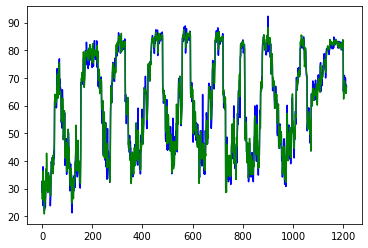

In [ ]:
start = 0
end = 3000

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot((test_y[start:end] * np.sqrt(var_test[4] + epsilon) + mean_test[4]), 'b', (predictions[start:end] * np.sqrt(var_test[4] + epsilon) + mean_test[4]), 'g')